In [20]:
%%time
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from adjustText import adjust_text


@dataclass
class Config:
    project_dir: Path = Path("../../")
    model_dir: Path = project_dir / "models"
    outputs_dir: Path = project_dir / "outputs"
    data_dir: Path = project_dir / "data"
    raw_dir: Path = data_dir / "raw"
    interim_dir: Path = data_dir / "interim"
    processed_dir: Path = data_dir / "processed"
    results_dir: Path = project_dir / "results"
    results_agg_dir: Path = results_dir / "agg"
    results_figs_dir: Path = results_dir / "figs"


config = Config()
sys.path.append(str(config.project_dir.resolve()))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CPU times: user 102 ms, sys: 56.9 ms, total: 158 ms
Wall time: 317 ms


In [54]:
df_orders = pd.read_csv(config.interim_dir / "olist_orders_customer_merged.csv")
df_item_products = pd.read_csv(
    config.interim_dir / "olist_item_product_seller_merged.csv"
)
df_orders_item_products_merged = pd.merge(
    df_orders, df_item_products, on="order_id", how="left"
)
assert (
    df_orders_item_products_merged["order_id"].nunique()
    == df_orders["order_id"].nunique()
)

df_orders_item_products_merged_for_categorize_items = df_orders_item_products_merged[
    [
        "order_id",
        "product_id",
        "product_category_name_english",
        "order_purchase_month",
        "sum_price_freight_by_order",
    ]
].drop_duplicates()

## 全期間における商品カテゴリー別売り上げランキング

In [55]:
agg_rev_by_category = (
    df_orders_item_products_merged_for_categorize_items.groupby(
        "product_category_name_english"
    )["sum_price_freight_by_order"]
    .sum()
    .sort_values(ascending=False)
    .reset_index(name="sum")
)
agg_rev_by_category.to_csv(
    config.results_agg_dir / "product_category_sales_ranking.csv", index=False
)

## 売上上位10の商品カテゴリーを表示
agg_rev_by_category_df_top_10 = agg_rev_by_category.head(10).copy()
agg_rev_by_category_df_top_10["sum"] = agg_rev_by_category_df_top_10["sum"] / 1000
agg_rev_by_category_df_top_10 = agg_rev_by_category_df_top_10.rename(
    columns={"sum": "sum (thousand R$)"}
)

# 小数点以下2桁まで表示
agg_rev_by_category_df_top_10["sum (thousand R$)"] = agg_rev_by_category_df_top_10[
    "sum (thousand R$)"
].round(2)

display(agg_rev_by_category_df_top_10)

,product_category_name_english,sum (thousand R$)
0,health_beauty,1384.78
1,watches_gifts,1285.04
2,bed_bath_table,1151.66
3,sports_leisure,1084.44
4,computers_accessories,936.67
5,furniture_decor,778.02
6,housewares,702.97
7,cool_stuff,702.77
8,auto,651.01
9,toys,549.90


### 売り上げランキング上位の商品カテゴリーについて，月毎の売り上げ推移

In [4]:
from src.visualizer.vis_functions import plot_category_sales_trend

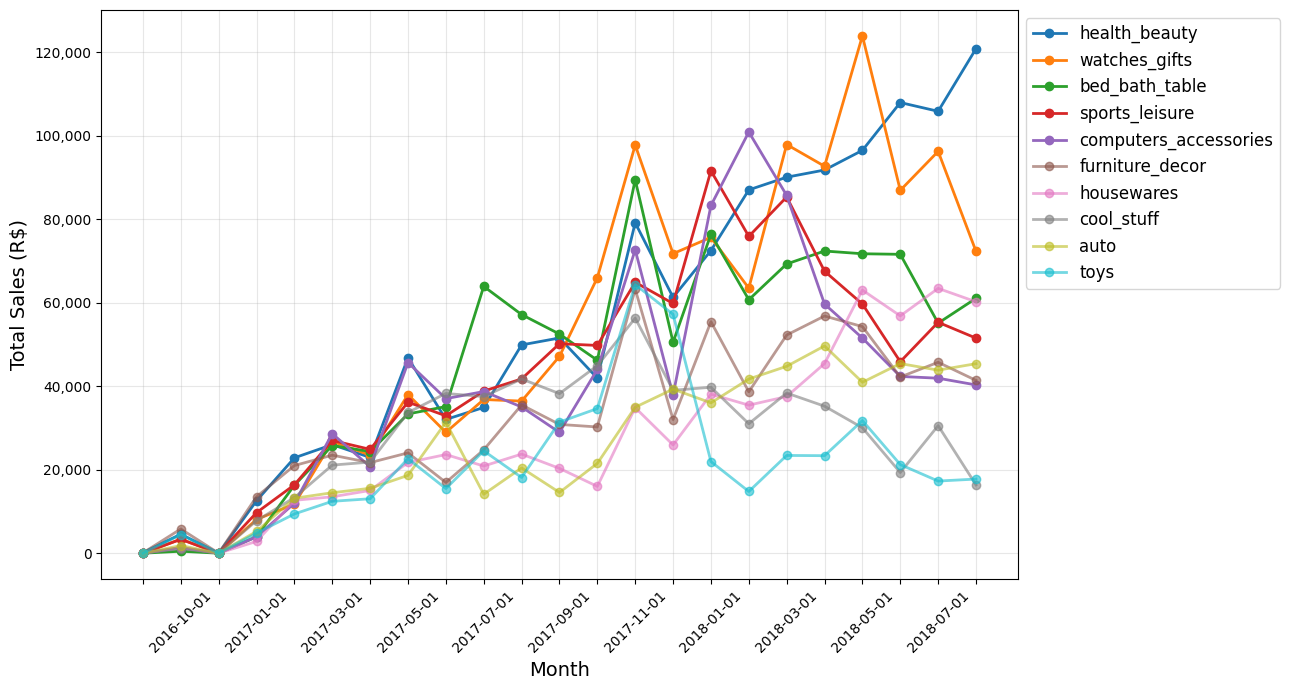

In [92]:
plot_category_sales_trend(
    categories=agg_rev_by_category_df_top_10["product_category_name_english"].to_list(),
    df_merged=df_orders_item_products_merged,
    start_date="2016-09",
    end_date="2018-08",
    title="Sales Trend for top 10 categories",
    agg_type="sales",
    figsize=(13, 7),
    output_path=config.results_figs_dir / "top_10_categories_sales_trend.png",
)

## データを以下のように前半と後半に分割

- 前半
    - 2017年2月から2017年10月
- 後半
    - 2017年12月から2018年8月
- ※　2017年11月はブラックフライデーによる外れ値のため除外

In [40]:
start_date, end_date = (
    df_orders_item_products_merged_for_categorize_items["order_purchase_month"].min(),
    df_orders_item_products_merged_for_categorize_items["order_purchase_month"].max(),
)
all_months = df_orders_item_products_merged.query(
    "order_purchase_month >= @start_date & order_purchase_month <= @end_date"
)["order_purchase_month"].unique()

all_categories = df_orders_item_products_merged_for_categorize_items[
    "product_category_name_english"
].unique()

# 全ての月とカテゴリーの組み合わせを作成
month_category_combinations = pd.MultiIndex.from_product(
    [all_months, all_categories],
    names=["order_purchase_month", "product_category_name_english"],
)

monthly_category_counts_by_revs = (
    df_orders_item_products_merged_for_categorize_items.groupby(
        ["order_purchase_month", "product_category_name_english"]
    )["sum_price_freight_by_order"]
    .sum()
    .reindex(month_category_combinations, fill_value=0)
    .reset_index(name="sum")
    .sort_values("order_purchase_month")
)
# 差分を計算
ff_diff_df = pd.DataFrame(
    {
        "2017-02": monthly_category_counts_by_revs.query(
            "order_purchase_month == '2017-02'"
        ).set_index("product_category_name_english")["sum"],
        "2017-10": monthly_category_counts_by_revs.query(
            "order_purchase_month == '2017-10'"
        ).set_index("product_category_name_english")["sum"],
    }
)
# 差分と変化率を計算
ff_diff_df["difference"] = ff_diff_df["2017-10"] - ff_diff_df["2017-02"]
ff_diff_df["change_rate"] = (
    (ff_diff_df["2017-10"] - ff_diff_df["2017-02"]) / ff_diff_df["2017-02"] * 100
).round(2)
ff_diff_df = ff_diff_df.sort_values("difference", ascending=False)
# 差分を計算
sf_diff_df = pd.DataFrame(
    {
        "2017-12": monthly_category_counts_by_revs.query(
            "order_purchase_month == '2017-12'"
        ).set_index("product_category_name_english")["sum"],
        "2018-08": monthly_category_counts_by_revs.query(
            "order_purchase_month == '2018-08'"
        ).set_index("product_category_name_english")["sum"],
    }
)
# 差分と変化率を計算
sf_diff_df["difference"] = sf_diff_df["2018-08"] - sf_diff_df["2017-12"]
sf_diff_df["change_rate"] = (
    (sf_diff_df["2018-08"] - sf_diff_df["2017-12"]) / sf_diff_df["2017-12"] * 100
).round(2)
sf_diff_df = sf_diff_df.sort_values("difference", ascending=False)
diff_by_category_name_df = pd.merge(
    ff_diff_df,
    sf_diff_df,
    left_index=True,
    right_index=True,
    suffixes=("_first", "_second"),
)
diff_by_category_name_df = pd.merge(
    diff_by_category_name_df,
    monthly_category_counts_by_revs.groupby("product_category_name_english")[
        "sum"
    ].sum(),
    left_index=True,
    right_index=True,
    how="left",
).sort_values("sum", ascending=False)

## 売り上げ上位

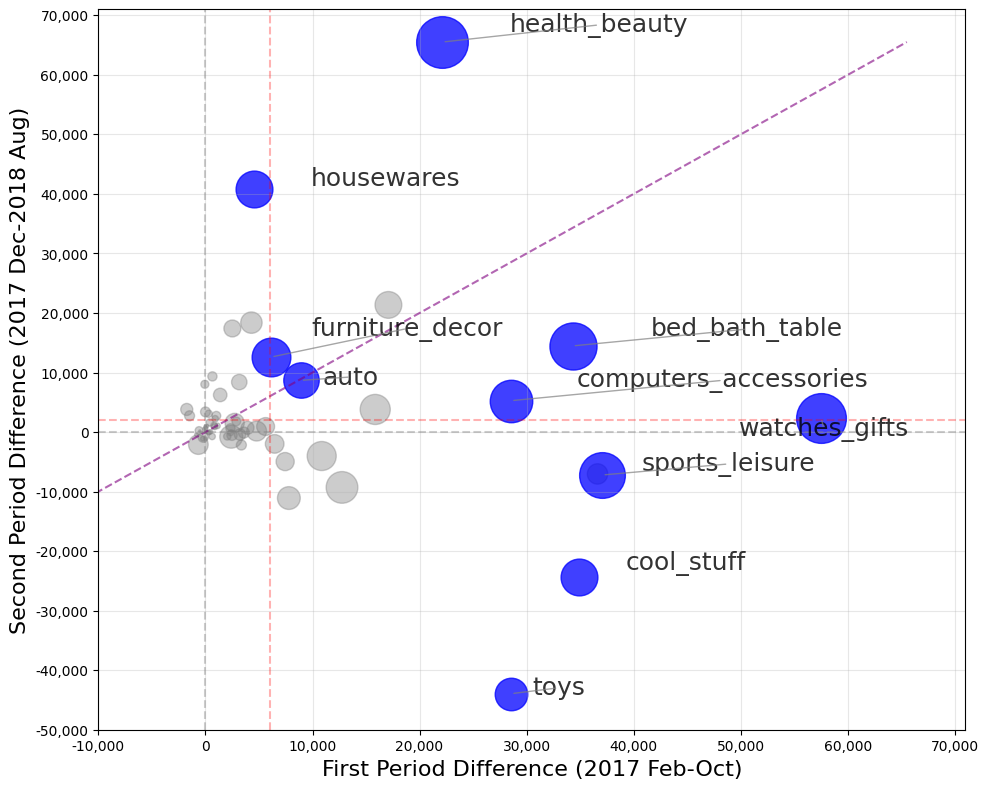

In [70]:
top_10_categories = agg_rev_by_category_df_top_10[
    "product_category_name_english"
].to_list()
other_categories = agg_rev_by_category["product_category_name_english"][10:].to_list()

# プロットの作成
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(
    diff_by_category_name_df.loc[other_categories, "difference_first"],
    diff_by_category_name_df.loc[other_categories, "difference_second"],
    s=diff_by_category_name_df.loc[other_categories, "sum"] / 1000,
    alpha=0.4,
    c="gray",
    label="Others",
)
texts = []
for category in top_10_categories:
    scatter = ax.scatter(
        diff_by_category_name_df.loc[category, "difference_first"],
        diff_by_category_name_df.loc[category, "difference_second"],
        s=diff_by_category_name_df.loc[category, "sum"] / 1000,
        alpha=0.75,
        c="blue",
        label=category,
    )
    text = ax.text(
        diff_by_category_name_df.loc[category, "difference_first"],
        diff_by_category_name_df.loc[category, "difference_second"],
        category,
        fontsize=18,
        alpha=0.8,
    )
    texts.append(text)
# y=xの直線を追加
min_val = min(
    diff_by_category_name_df["difference_first"].min(),
    diff_by_category_name_df["difference_second"].min(),
)
max_val = max(
    diff_by_category_name_df["difference_first"].max(),
    diff_by_category_name_df["difference_second"].max(),
)
ax.plot(
    [min_val, max_val], [min_val, max_val], "--", color="purple", alpha=0.6, label="y=x"
)
adjust_text(
    texts,
    arrowprops=dict(arrowstyle="-", color="gray", alpha=0.7),
    expand_points=(1.0, 1.0),
    force_points=(0.1, 0.1),
)
ax.axhline(y=0, color="gray", linestyle="--", alpha=0.4)
ax.axvline(x=0, color="gray", linestyle="--", alpha=0.4)
ax.axhline(
    y=diff_by_category_name_df["difference_second"].mean(),
    color="red",
    linestyle="--",
    alpha=0.3,
)
ax.axvline(
    x=diff_by_category_name_df["difference_first"].mean(),
    color="red",
    linestyle="--",
    alpha=0.3,
)
ax.set_xlabel("First Period Difference (2017 Feb-Oct)", fontsize=16)
ax.set_ylabel("Second Period Difference (2017 Dec-2018 Aug)", fontsize=16)
# ax.set_title(
#     "Category Growth Comparison",
#     fontsize=16,
# )
ax.set_xlim(xmin=-5000)
ax.set_xticks(np.arange(-10000, max_val + 10000, 10000))
ax.set_yticks(np.arange(-50000, max_val + 10000, 10000))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{int(x):,}"))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{int(x):,}"))
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(config.results_figs_dir / "category_growth_comparison.png")
plt.show()

### categorize_growth_by_category_name

- high_growth
    - "health_beauty"
    - "housewares"
    - ("furniture_decor")
- low_growth
    - "watches_gifts"
    - "cool_stuff"
    - "toys"
    - "sports_leisure"
    - "bed_bath_table"
    - "computers_accessories"


In [71]:
low_growth_categories = [
    "watches_gifts",
    "cool_stuff",
    "toys",
    "sports_leisure",
    "bed_bath_table",
    "computers_accessories",
]
high_growth_categories = ["health_beauty", "housewares"]

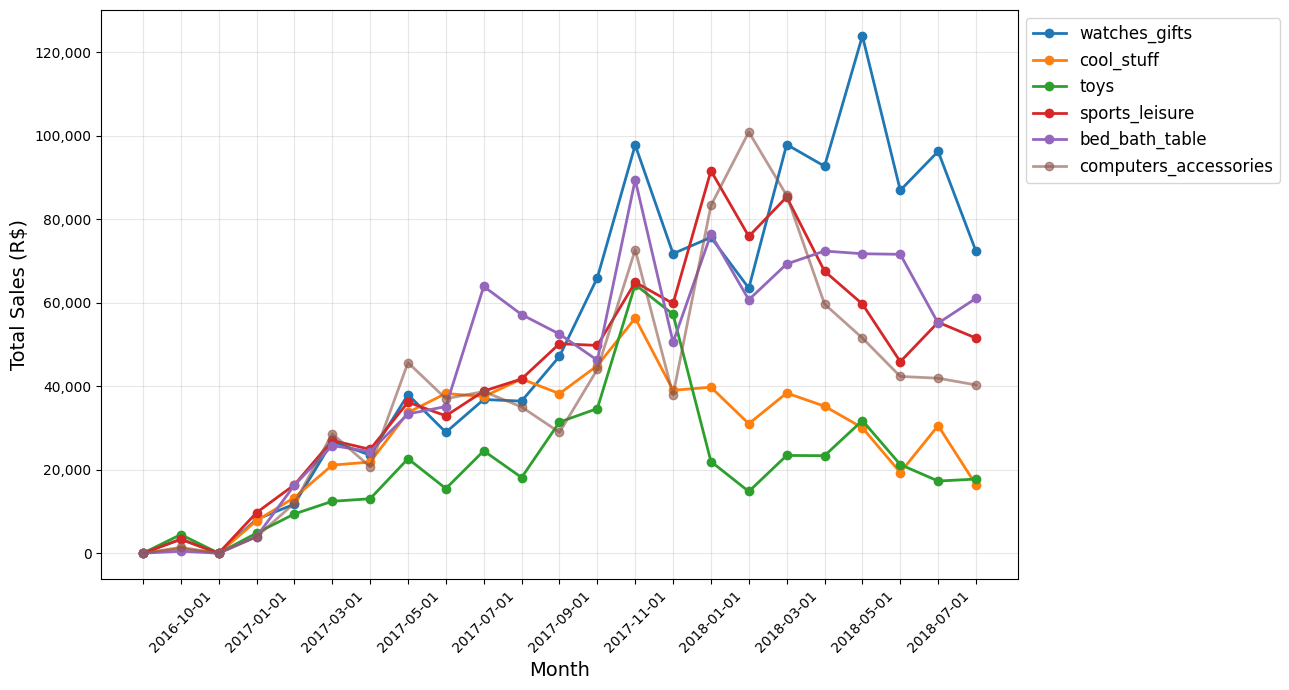

In [86]:
plot_category_sales_trend(
    categories=low_growth_categories,
    df_merged=df_orders_item_products_merged,
    start_date="2016-09",
    end_date="2018-08",
    title="Sales Trend for low growth categories",
    agg_type="sales",
    figsize=(13, 7),
)

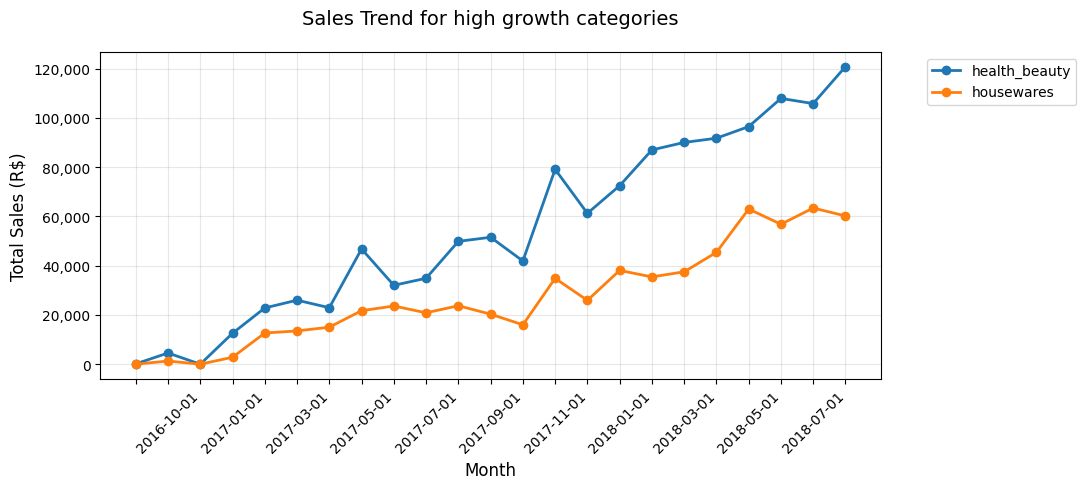

In [78]:
plot_category_sales_trend(
    categories=high_growth_categories,
    df_merged=df_orders_item_products_merged,
    start_date="2016-09",
    end_date="2018-08",
    title="Sales Trend for high growth categories",
    agg_type="sales",
    figsize=(11, 5),
)